# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or functional needs repair.


## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Join the kaggle competition, and download the water pump dataset.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and validation sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `ydata-profiling`
- `sklearn`

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle competition website (the URL is given on Canvas). Go to the **Rules** page. Accept the rules of the competition and download the dataset. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [4]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path,
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path,
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)

    return df

**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [ ]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [14]:
df = wrangle((DATA_PATH+'waterpumps/train_features.csv'), (DATA_PATH+'waterpumps/train_labels.csv'))
X_test = wrangle(DATA_PATH +'waterpumps/test_features.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 59399 entries, 69572.0 to 26348.0
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             17761 non-null  float64
 1   gps_height             38962 non-null  float64
 2   longitude              57587 non-null  float64
 3   latitude               57587 non-null  float64
 4   num_private            757 non-null    float64
 5   basin                  59399 non-null  object 
 6   region                 59399 non-null  object 
 7   region_code            59399 non-null  int64  
 8   district_code          59376 non-null  float64
 9   population             38019 non-null  float64
 10  public_meeting         56066 non-null  object 
 11  scheme_management      55522 non-null  object 
 12  permit                 56343 non-null  object 
 13  construction_year      38691 non-null  float64
 14  extraction_type        59399 non-null  objec

In [16]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,17761.000000,38962.000000,57587.000000,57587.000000,757.000000,59399.000000,59376.000000,38019.000000,38691.000000
mean,1062.351942,1018.860839,35.149704,-5.885586,37.204756,15.297025,5.631973,281.087167,1996.814686
std,5409.344940,612.566092,2.607437,2.809899,101.958683,17.587554,9.634952,564.687660,12.472045
min,0.200000,-90.000000,29.607122,-11.649440,1.000000,1.000000,1.000000,1.000000,1960.000000
25%,50.000000,393.000000,33.285198,-8.643850,6.000000,5.000000,2.000000,40.000000,1987.000000
50%,250.000000,1167.000000,35.005964,-5.172737,15.000000,12.000000,3.000000,150.000000,2000.000000
75%,1000.000000,1498.000000,37.233727,-3.372822,42.000000,17.000000,5.000000,324.000000,2008.000000
max,350000.000000,2770.000000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000,2013.000000


# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [17]:
X = df.drop(columns=['status_group'])
y = df['status_group']

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X,y, random_state = 42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((44549, 29), (14850, 29), (44549,), (14850,))

In [20]:
y_train.value_counts(normalize=True)

functional                 0.542122
non functional             0.384476
functional needs repair    0.073402
Name: status_group, dtype: float64

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [21]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5421221576241891


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [43]:
model_dt = make_pipeline(
     OneHotEncoder(use_cat_names=True),
     SimpleImputer(),
     DecisionTreeClassifier(min_samples_leaf = 10, random_state= 42))

model_dt.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(min_samples_leaf=10, random_state=42))])

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [44]:
print('Train Accuracy:', model_dt.score(X_train, y_train))
print('Validation Accuracy:', model_dt.score(X_val, y_val))

Train Accuracy: 0.8376619003793576
Validation Accuracy: 0.7668013468013468


In [46]:
y_pred = model_dt.predict(X_test)

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [32]:
# Use this cell to experiment and then change
# your model hyperparameters in Task 6
model_dt = make_pipeline(
     OneHotEncoder(use_cat_names=True),
     SimpleImputer(),
     DecisionTreeClassifier(max_depth=10, random_state=42))

model_dt.fit(X_train, y_train)

print('Train Accuracy:', model_dt.score(X_train, y_train))
print('Validation Accuracy:', model_dt.score(X_val, y_val))

Train Accuracy: 0.7625086982872792
Validation Accuracy: 0.7484848484848485


# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

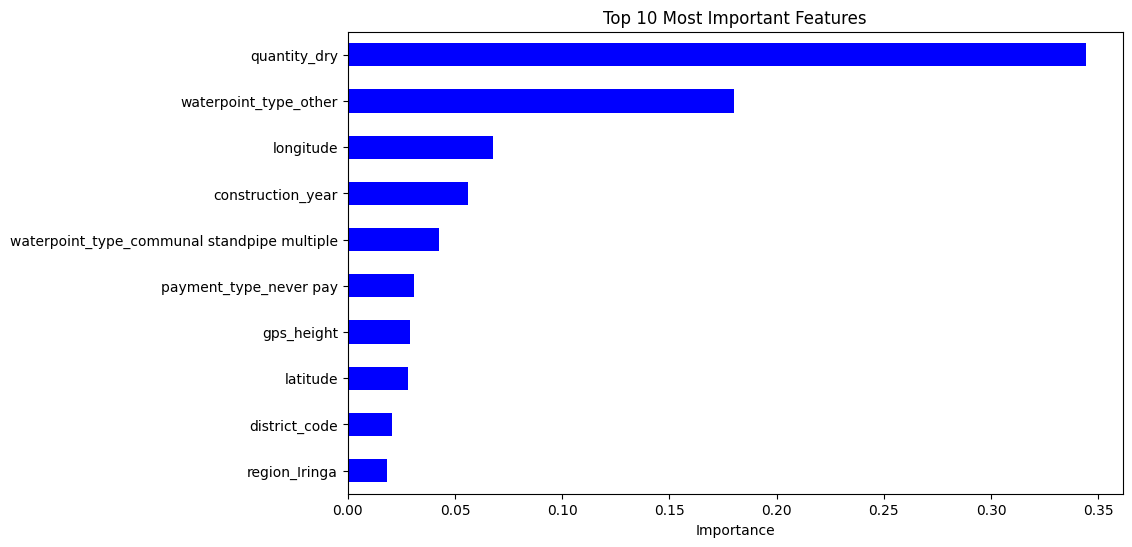

In [42]:
model = model_dt.named_steps['decisiontreeclassifier']
encoder = model_dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoder.feature_names_out_)

top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.sort_values().plot.barh(color='blue')
plt.xlabel('Importance')
plt.title('Top 10 Most Important Features')
plt.show()


In [47]:
#submission
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
my_submission = sample_submission.copy()
my_submission['status_group'] = y_pred
my_submission.to_csv('water-kaggle-1.csv', index=False)
from google.colab import files
files.download('water-kaggle-1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>